# Creating the model
In the last notebook, we've preprocessed and saved the data and the normalization paramters.

Now let's use this data to train the model and make predcitions

In [0]:
# import the required libraries
import glob
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
from utils import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout

## Load the saved data
If you recall from last time we've saved two versions of the data, one that is normalized per point and one that is normalized using the mean of all points.

In this notebook, I'll be using the data normalized using the mean of all points, but I'll leave comments to how to use the vector as well

In [3]:
## for the vector normalized data
# X = np.load("data/features_vector_normalized.npy")
# y = np.load("data/labels_vector_normalized.npy")

## for the scaler normalized data
X = np.load("data/features_scaler_normalized.npy")
y = np.load("data/labels_scaler_normalized.npy")


X = X.reshape((3462, 90, 90,1))
y = y.reshape(3462, 136)
print(X.shape, y.shape)
print(X[0].shape, y[0].shape)

(3462, 90, 90, 1) (3462, 136)
(90, 90, 1) (136,)


In [0]:
## for the vector normalized data
# grand_mean = np.load("data/grand_mean.npy").reshape(-1, 1)
# grand_std = np.load("data/grand_std.npy").reshape(-1, 1)
# grand_mean.shape

## for the scaler normalized data
grand_mean = 104.47
grand_std = 43.17

**Just want to make sure every thing works fine here**

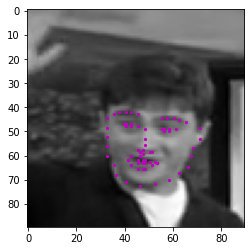

In [5]:
kpts = (y[6] * grand_std) + grand_mean
show_kpts(X[6].reshape(90, 90), kpts.reshape(-1, 2), cmap="gray")

## Creating the model
**This model looks small, but believe me ... it isn't**

In [0]:
model = Sequential([
    Conv2D(32, (5, 5), activation="relu", input_shape=[90, 90, 1]),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(64, (5, 5), activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv2D(128, (5, 5), activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(256, (5, 5), activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    
    Flatten(),

    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(136)
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 86, 86, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 39, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 39, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 39, 64)        0

In [0]:
tf.keras.backend.clear_session()
model.compile(
    loss=tf.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics=['accuracy']
)

## Training the model
Some thing I really like doing is use so many epochs and set early stopping.

Just because I can.

In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# mcp_save = ModelCheckpoint('landmark_detection1.0.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [10]:
history = model.fit(X, y, validation_split=0.1, epochs=120, callbacks=[earlyStopping])

Epoch 1/120
98/98 [==============================] - 14s 141ms/step - loss: 0.3289 - accuracy: 0.0421 - val_loss: 0.3372 - val_accuracy: 0.0086
Epoch 2/120
98/98 [==============================] - 13s 133ms/step - loss: 0.1420 - accuracy: 0.0636 - val_loss: 13.9606 - val_accuracy: 0.0000e+00
Epoch 3/120
98/98 [==============================] - 13s 133ms/step - loss: 0.0895 - accuracy: 0.1024 - val_loss: 0.1531 - val_accuracy: 0.0576
Epoch 4/120
98/98 [==============================] - 13s 133ms/step - loss: 0.0655 - accuracy: 0.1387 - val_loss: 0.0288 - val_accuracy: 0.0634
Epoch 5/120
98/98 [==============================] - 13s 133ms/step - loss: 0.0499 - accuracy: 0.1663 - val_loss: 0.0290 - val_accuracy: 0.3170
Epoch 6/120
98/98 [==============================] - 13s 133ms/step - loss: 0.0376 - accuracy: 0.1814 - val_loss: 0.0116 - val_accuracy: 0.3026
Epoch 7/120
98/98 [==============================] - 13s 133ms/step - loss: 0.0276 - accuracy: 0.2286 - val_loss: 0.0101 - val_accu

## Using the model
**Moment of truth, let's run this bad boy on an image that it has never seen before**

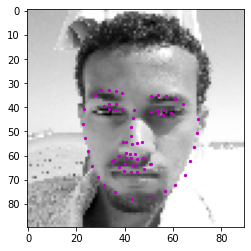

In [12]:
# make this dict because the preprocessing functions are defined to take a dict
sample = { "image" : mpimg.imread(os.path.join('data/test', 'test2.jpg')), "keypoints": None }
sample = rescale(sample, (100, 100))
sample = randomCrop(sample, (90, 90))
sample = normalize(sample, grand_mean, grand_std)
img = sample["image"]

kpts = model.predict(img.reshape(1, 90, 90, 1))
kpts = (kpts * grand_std) + grand_mean
show_kpts(img.reshape(90, 90), kpts.reshape(-1, 2), cmap="gray")

# Awesome!
The model is working as expected, and **MAN**, do I look good!

But don't let my sexy face distract you or make you forget that we need to **Save the model**

In [13]:
# saving the architecture of the model
model_json = model.to_json()
with open("models/Original_dense_constant_4.0.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("models/Original_dense_constant_4.0.h5")
print("Saved model to disk")


Saved model to disk


**Now, we can load the model whenever we want and use it as before**

In [0]:
# load json and create model
json_file = open('models/Original_dense_constant_4.0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("drive/My Drive/Original_dense_constant_4.0.h5")
print("Loaded model from disk")

Loaded model from disk


## Congrats, friend
Now you have a working model.

Hopefully, I'll make a notebook in the future that uses this model to add filters to your lovely face.

Stay tuned